In [1]:
from model import *
import numpy as np


# Plotting
from matplotlib_scalebar.scalebar import ScaleBar
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
%matplotlib tk

import json
import os

# For file dialogs
import tkinter as tk
from tkinter import filedialog
root = tk.Tk()
root.withdraw()

''

# Examining the scattering models
Comparing own implementation of Rayleigh scattering to Mie scattering for GNP

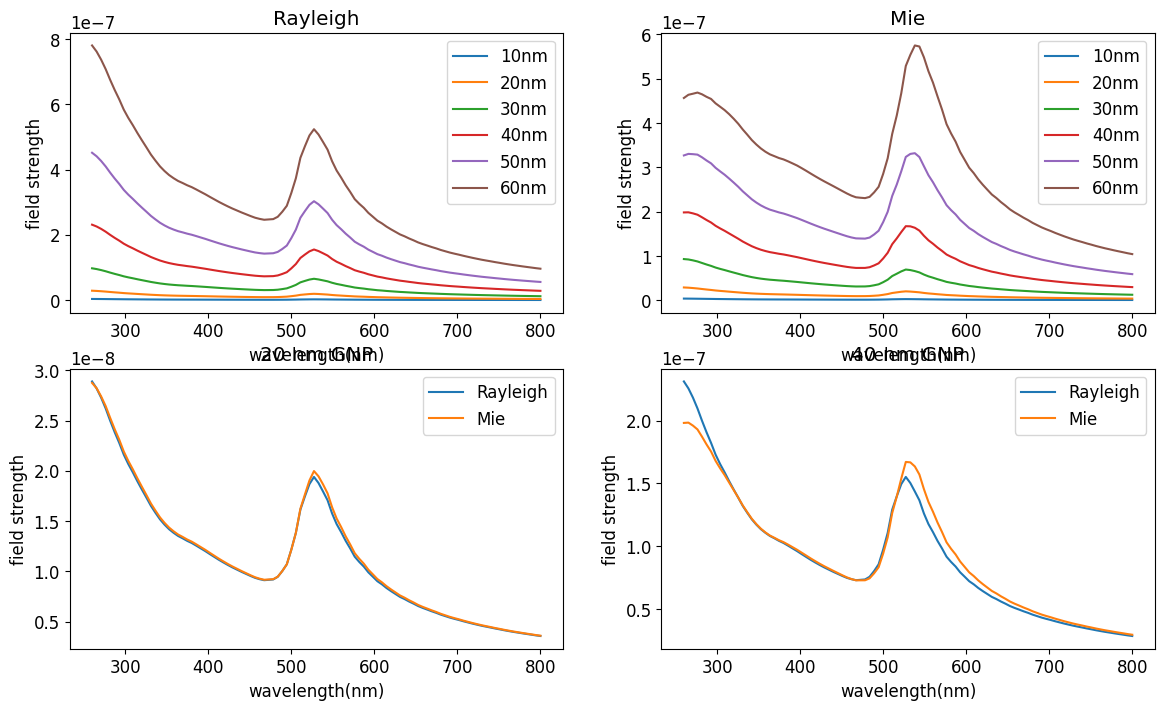

In [69]:
fig, ax = plt.subplots(2,2, figsize=(14, 8))
ax = ax.ravel()

for diameter in np.linspace(10, 60, 6)*10**-9:
    params = DesignParams(
        a = diameter/2,
        z_focus = diameter/2,
        z_p = diameter/2,
    )

    wavelens = np.linspace(260, 800, 100)*10**-9
    scatter_intensity_rayleigh = np.zeros(len(wavelens))
    scatter_intensity_mie = np.zeros(len(wavelens))
    for i, wavelen in enumerate(wavelens):
        params.wavelen = wavelen
        params.n_scat = n_gold(wavelen)
        scatter_field = calculate_scatter_field(params)
        scatter_intensity_rayleigh[i] = np.abs(scatter_field[0,0,0])
        scatter_field = calculate_scatter_field_mie(params)
        scatter_intensity_mie[i] = np.abs(scatter_field[0,0,0])

    ax[0].plot(wavelens*10**9, scatter_intensity_rayleigh, label=f'{diameter*10**9:.0f}nm')
    ax[1].plot(wavelens*10**9, scatter_intensity_mie, label=f'{diameter*10**9:.0f}nm')

for j, diameter in enumerate(np.array([20, 40])*10**-9):
    params = DesignParams(
        a = diameter/2,
        z_focus = 0,
        z_p = 0,
    )

    wavelens = np.linspace(260, 800, 100)*10**-9
    scatter_intensity_rayleigh = np.zeros(len(wavelens))
    scatter_intensity_mie = np.zeros(len(wavelens))
    for i, wavelen in enumerate(wavelens):
        params.wavelen = wavelen
        params.n_scat = n_gold(wavelen)
        scatter_field = calculate_scatter_field(params)
        scatter_intensity_rayleigh[i] = np.abs(scatter_field[0,0,0])
        scatter_field = calculate_scatter_field_mie(params)
        scatter_intensity_mie[i] = np.abs(scatter_field[0,0,0])

    ax[2+j].plot(wavelens*10**9, scatter_intensity_rayleigh, label='Rayleigh')
    ax[2+j].plot(wavelens*10**9, scatter_intensity_mie, label='Mie')


ax[0].set_title('Rayleigh')
ax[1].set_title('Mie')
ax[2].set_title('20 nm GNP')
ax[3].set_title('40 nm GNP')
for axis in ax:
    axis.set_xlabel('wavelength(nm)')
    axis.set_ylabel('field strength')
    axis.legend()
plt.show()


# Vary Focus or Position

In [13]:
save_path = filedialog.asksaveasfilename(
    title="Save Simulation to File",
    filetypes=[("Data", "*.npz")]  # Optional filter
)
if (save_path):
    # Move particle plot
    z_focus = np.linspace(-1, 1, 100)*10**-6
    z_p = 0

    config_path = filedialog.askopenfilename(
        title="Load previous parameters",
        filetypes=[("Data", "*.npz")]  # Optional filter
    )
    if config_path:
        data = np.load(config_path, allow_pickle=True)
        params = data['params'].item()
    else:
        params = DesignParams(
            t_oil = 100*10**-6,
            n_oil = 1.5023,
            n_glass = 1.4985,
            t_glass= 179*10**-6,
            n_scat = n_gold(wavelength),
            n_medium = n_water,
            wavelength = 525*10**-9,
            a = 20*10**-9/2)
    

    params.z_focus = z_focus
    params.z_p = z_p

    scatter_field = calculate_scatter_field(params)

    if isinstance(z_focus, (list, np.ndarray)):
        intensities = np.zeros((len(z_focus), len(xs), len(ys)))
        p = replace(params)
        for m, z_f in enumerate(z_focus):
            p.z_focus = z_f
            intensity = calculate_intensities(scatter_field, p)
            intensities[m] = intensity['tot']
    elif isinstance(z_p, (list, np.ndarray)):
        intensities = np.zeros((len(z_p), len(xs), len(ys)))
        p = replace(params)
        for m, z_particle in enumerate(z_p):
            p.z_p = z_particle
            intensity = calculate_intensities(scatter_field, p)
            intensities[m] = intensity['tot']
    
    np.savez(save_path, intensity=intensities, params=params)



In [16]:
# Plot Focus Data
file_path = filedialog.askopenfilename(
    title="Select a File",
    filetypes=[("Data", "*.npz")]
)
if (file_path):
   data = np.load(file_path, allow_pickle=True)
   intensities = data['intensity']
   params = data['params'].item()

   
   if isinstance(params.z_focus, (list, np.ndarray)):
      z = params.z_focus
      z_vary = 'focus'
   elif isinstance(params.z_p, (list, np.ndarray)):
      z = params.z_p
      z_vary = 'position'
   else:
      quit()

   fig, ax = plt.subplots(1,2, figsize=(12, 6))
   plt.rcParams.update({'font.size': 12})
   #extremum = max(np.abs(np.min(intensities) - 1), np.max(intensities) - 1)
   im = ax[0].imshow(intensities[0], cmap='gray', origin='lower')
   plt.colorbar(im, ax=ax[0])
   scalebar = ScaleBar(pxsize)
   ax[0].add_artist(scalebar)
   ax[0].axis('off')
   fig.suptitle(f'Varying {z_vary}')
   contrast_plot = ax[1].plot(intensities[:,pixels//2,pixels//2] - 1, z*10**6)
   contrast = ax[1].plot(intensities[0,pixels//2,pixels//2] - 1, z[0]*10**6, 'ro')[0]
   ax[1].set_ylabel(f'{z_vary} (micron)')
   ax[1].set_xlabel('contrast')


   def update(frame):
      im.set_array(intensities[frame])
      ax[0].set_title(f'{z_vary}: {z[frame]*10**6:.2f} micron')
      contrast.set_xdata([intensities[frame,pixels//2,pixels//2] - 1])
      contrast.set_ydata([z[frame]*10**6])
      return [im, contrast]

   ani = FuncAnimation(fig, update, frames=len(intensities), interval=100)
   plt.show()
   #ani.save('focusgnp.gif')
   #plt.close()
   #display(HTML(ani.to_jshtml()))
   

# Making a simple image of a focused GNP on the surface

In [12]:
# Single plot

wavelength = 525*10**-9
diameter = 60*10**-9
radius = diameter/2
#polarization = np.array([1, 0, 0]) # x polarization

params = DesignParams(
    polarization = np.array([1,0,0]),
    z_p = 0,
    z_focus = 0,
    wavelen = wavelength,
    n_scat = n_ps,
    n_medium = n_water,
    a = radius)

setup_params = SetupParams(roi_size=2*10**-6, magnification=1000)
camera = Camera(setup_params)

scatter_field = calculate_scatter_field(params)
intensity = calculate_intensities(scatter_field, params, camera)

fig, ax = plt.subplots()
p = ax.imshow(intensity['scat'])
ax.set_axis_off()
fig.colorbar(p)
ax.add_artist(ScaleBar(camera.pxsize_obj))

# 3x1 plot
# fig, ax = plt.subplots(1, 3, figsize=(12,4))

# for i, intens in enumerate(['if', 'scat', 'tot']):
#     p = ax[i].imshow(intensity[intens])
#     ax[i].set_axis_off()
#     scalebar = ScaleBar(pxsize)
#     ax[i].add_artist(scalebar)
#     fig.colorbar(p, ax=ax[i])
#     ax[i].set_title(intens + ' intensity')

# plt.show()

In [3]:
# Move focus contrast plot


def centroid_contrast_variable_focus(p, z_focuses):
    params = p
    focus_contrasts = np.zeros(len(z_focuses))

    # Custom camera
    xs = np.array([0])
    ys = np.array([0])
    rs = np.array([0])
    phi = np.array([0])
    xy_rs = [[0]]
    camera_params = (xs, ys, rs, phi, xy_rs)
    scatter_field = calculate_scatter_field(params)
    for m, z_focus in enumerate(z_focuses):
        params.z_focus = z_focus
        intensity = calculate_intensities(scatter_field, params, camera_params)
        focus_contrasts[m] = intensity['sig'][0,0]
    
    return focus_contrasts

wavelength = 525*10**-9

z_focuses_11 = np.linspace(-1, 1, 200)*10**-6
z_focuses_27 = np.linspace(2, 7, 200)*10**-6

diameter = 60*10**-9
radius = diameter/2
params_1 = DesignParams(
        z_p = 0,
        n_oil0 = 1.5,
        n_glass0 = 1.5,
        t_oil0 = 100*10**-6,
        t_glass0 = 170*10**-6,
        n_oil = 1.5018,
        n_glass = 1.499,
        t_glass= 184*10**-6,
        wavelen = wavelength,
        n_scat = n_ps,
        n_medium = n_water,
        a = radius)
focus_contrasts_ps0 = centroid_contrast_variable_focus(params_1, z_focuses_11)
diameter = 20*10**-9
radius = diameter/2
params_2 = DesignParams(
        z_p = 0,
        n_oil0 = 1.5,
        n_glass0 = 1.5,
        t_oil0 = 100*10**-6,
        t_glass0 = 170*10**-6,
        n_oil = 1.5023,
        n_glass = 1.4985,
        t_glass= 179*10**-6,
        wavelen = wavelength,
        n_scat = n_gold(wavelength),
        n_medium = n_water,
        a = radius)
focus_contrasts_gold0 = centroid_contrast_variable_focus(params_2, z_focuses_11)
params_3 = DesignParams(
        z_p = 4*10**-6,
        n_oil0 = 1.5,
        n_glass0 = 1.5,
        t_oil0 = 100*10**-6,
        t_glass0 = 170*10**-6,
        n_oil = 1.5023,
        n_glass = 1.4985,
        t_glass= 179*10**-6,
        wavelen = wavelength,
        n_scat = n_gold(wavelength),
        n_medium = 1.33,
        a = radius)
focus_contrasts_gold4 = centroid_contrast_variable_focus(params_3, z_focuses_27)

In [4]:
fig, ax = plt.subplots(1,3, figsize=(12,4))
ax[0].plot(focus_contrasts_ps0, z_focuses_11/10**-6)
ax[1].plot(focus_contrasts_gold0, z_focuses_11/10**-6)
ax[2].plot(focus_contrasts_gold4, z_focuses_27/10**-6)
for axis in ax:
    axis.set_ylabel('focus (micron)')
    axis.set_xlabel('contrast')
    axis.grid()

ax[0].set_title('Polystyrene NP at 0 micron')
ax[1].set_title('GNP at 0 micron')
ax[2].set_title('GNP at 4 micron')

plt.show()

In [6]:
# Move focus contrast plot


def centroid_contrast_variable_particle(p, z_particles):
    params = p
    contrasts = np.zeros(len(z_particles))

    # Custom camera
    xs = np.array([0])
    ys = np.array([0])
    rs = np.array([0])
    phi = np.array([0])
    xy_rs = [[0]]
    camera_params = (xs, ys, rs, phi, xy_rs)
    scatter_field = calculate_scatter_field(params)
    for m, z_p in enumerate(z_particles):
        params.z_p = z_p
        intensity = calculate_intensities(scatter_field, params, camera_params)
        contrasts[m] = intensity['sig'][0,0]
    
    return contrasts

wavelength = 525*10**-9

diameter = 10*10**-9
radius = diameter/2
z_particles = np.linspace(0, 3.12*10**-6, 1000)
params_m = DesignParams(
        z_focus = 1.5*10**-6,
        n_oil0 = 1.5,
        n_glass0 = 1.5,
        t_oil0 = 100*10**-6,
        t_glass0 = 170*10**-6,
        n_oil = 1.5018,
        n_glass = 1.499,
        t_glass= 184*10**-6,
        wavelen = wavelength,
        n_scat = n_gold(wavelength),
        n_medium = n_glyc,
        a = radius)
move_contrasts_gnp = centroid_contrast_variable_particle(params_m, z_particles)

In [6]:
fig, ax = plt.subplots(1, figsize=(4,6))
ax.plot(move_contrasts_gnp, z_particles/10**-6)
ax.set_ylabel('particle position (micron)')
ax.set_xlabel('contrast')
ax.grid()

In [7]:
# Contrast plot

diameters = np.linspace(2, 80, 1000)*10**-9
radii = diameters/2
wavelength = 525*10**-9

params = DesignParams(
    z_focus = 0*10**-6,
    z_p = 0*10**-6,
    wavelen = wavelength,
    n_scat = n_gold(wavelength),
    n_medium = n_water)
    


contrast = np.zeros_like(radii)
scatter_intensity = np.zeros_like(radii)
interference_intensity = np.zeros_like(radii)
# Custom one-pixel camera
xs2 = np.array([0])
ys2 = np.array([0])
rs2 = np.array([0])
phi2 = np.array([0])
xy_rs2 = [[0]]
cparams = (xs2, ys2, rs2, phi2, xy_rs2)
for i, radius in enumerate(radii):
    params.a = radius
    
    scatter_intensity[i] = 0
    interference_intensity[i] = 0
    contrast[i] = 0
    scatter_field = calculate_scatter_field(params)
    intensity = calculate_intensities(scatter_field, params, cparams)
    scatter_intensity[i] += intensity['scat'][0,0]
    interference_intensity[i] += intensity['if'][0,0]
    contrast[i] += intensity['sig'][0,0]


In [8]:
# Contrast plot plot
fig, ax = plt.subplots(2,1, sharex=True, gridspec_kw={'hspace': 0})
ax[0].set_yscale('symlog', linthresh=0.1)

ax[0].plot(diameters[contrast>0]/10**-9, contrast[contrast>0], label='total contrast')
ax[0].set_ylim(0, np.max(scatter_intensity))
ax[0].plot(diameters[scatter_intensity>0]/10**-9, scatter_intensity[scatter_intensity>0], label='scatter contrast', color='red')
ax[0].plot(diameters[interference_intensity>0]/10**-9, interference_intensity[interference_intensity>0], label='interference contrast', color='green')
ax[1].plot(diameters[contrast<0]/10**-9, contrast[contrast<0])
ax[1].plot(diameters[scatter_intensity<0]/10**-9, scatter_intensity[scatter_intensity<0])
ax[1].plot(diameters[interference_intensity<0]/10**-9, interference_intensity[interference_intensity<0])
ax[0].legend()
ax[1].grid()
ax[1].set_ylim(np.min(contrast)*1.2, 0)
ax[1].set_xlabel('GNP diameter(nm)')
ax[0].grid()
ax[0].set_ylabel('Contrast')
ax[0].set_title('GNP size and contrast')
plt.show()